$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [240]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [241]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/nadavhalahmi/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/nadavhalahmi/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/nadavhalahmi/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [242]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


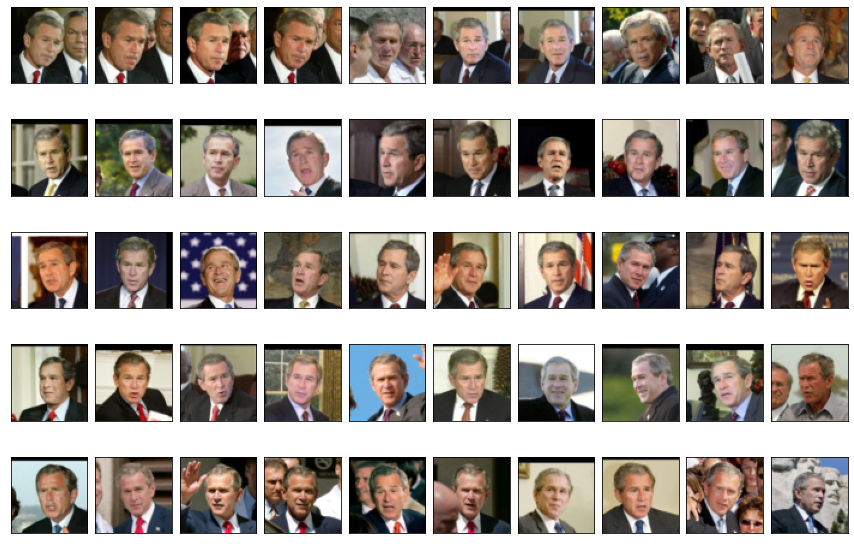

In [243]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [244]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [245]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (classifier_extractor): Sequential(
    (0): Linear(in_features=4096, out_features=4, bias=True)
    (1): LeakyReLU(negati

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [246]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [247]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [248]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

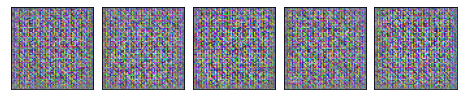

In [249]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [250]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.46it/s]
Discriminator loss: 0.9038152429792616
Generator loss:     0.9542338870210403
Saved checkpoint.


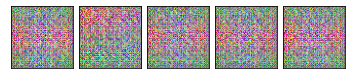

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.74it/s]
Discriminator loss: 0.4339979324075911
Generator loss:     1.7295258850318826
Saved checkpoint.


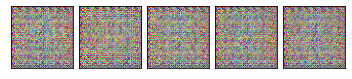

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.10it/s]
Discriminator loss: 0.3339562134610282
Generator loss:     2.315037359970412
Saved checkpoint.


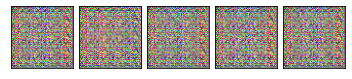

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.20it/s]
Discriminator loss: 0.2918272167444229
Generator loss:     2.745954558856843
Saved checkpoint.


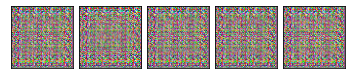

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
Discriminator loss: 0.24902754525343576
Generator loss:     3.0589285912475805
Saved checkpoint.


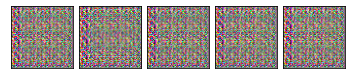

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
Discriminator loss: 0.22780678338474697
Generator loss:     3.3821584743217517
Saved checkpoint.


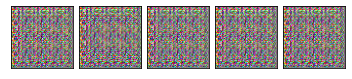

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
Discriminator loss: 0.23608123262723288
Generator loss:     3.461448703085977
Saved checkpoint.


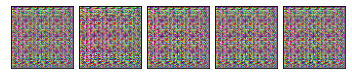

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
Discriminator loss: 0.20048093795776367
Generator loss:     3.5537065890116883
Saved checkpoint.


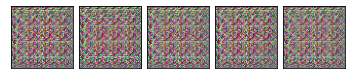

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.37it/s]
Discriminator loss: 0.12130186292860243
Generator loss:     3.78786386684574
Saved checkpoint.


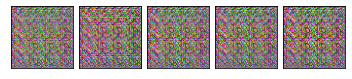

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.21it/s]
Discriminator loss: 0.19114429420895046
Generator loss:     3.862317141463468
Saved checkpoint.


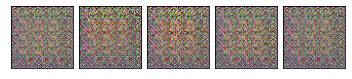

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.91it/s]
Discriminator loss: 0.4055172378818194
Generator loss:     3.70085788301356
Saved checkpoint.


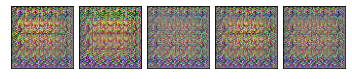

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.18it/s]
Discriminator loss: 1.7389629185199738
Generator loss:     2.2994251323864465
Saved checkpoint.


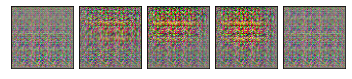

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.41it/s]
Discriminator loss: 0.3210270487599903
Generator loss:     2.142911289205761
Saved checkpoint.


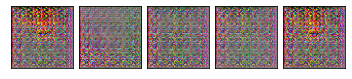

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.17it/s]
Discriminator loss: 0.2988609042432573
Generator loss:     2.5252840236062863
Saved checkpoint.


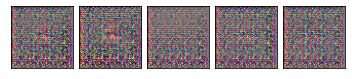

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.75it/s]
Discriminator loss: 0.3628678404622608
Generator loss:     2.8488115593441297
Saved checkpoint.


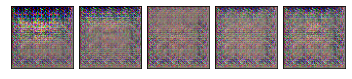

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.72it/s]
Discriminator loss: 0.5660065180725522
Generator loss:     2.914532864482569
Saved checkpoint.


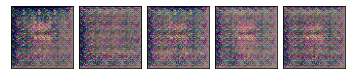

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.63it/s]
Discriminator loss: 2.3179875347349377
Generator loss:     1.998825661330582
Saved checkpoint.


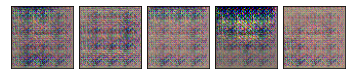

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.05it/s]
Discriminator loss: 1.1800235112508137
Generator loss:     1.0114277764534656
Saved checkpoint.


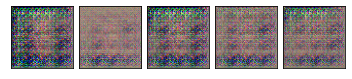

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.89it/s]
Discriminator loss: 0.8909956680403815
Generator loss:     1.3103122791759316
Saved checkpoint.


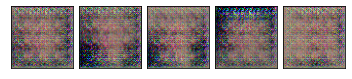

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.68it/s]
Discriminator loss: 0.5310264031092325
Generator loss:     1.9873630982853518
Saved checkpoint.


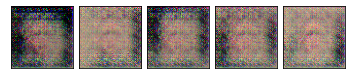

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.50it/s]
Discriminator loss: 0.5267566707399156
Generator loss:     2.2501481788575983
Saved checkpoint.


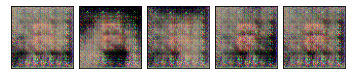

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.37it/s]
Discriminator loss: 0.3870450837744607
Generator loss:     2.188633105588362
Saved checkpoint.


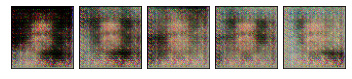

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.59it/s]
Discriminator loss: 1.8441120667590036
Generator loss:     2.5686951704625063
Saved checkpoint.


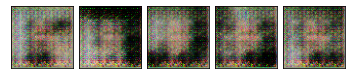

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.64it/s]
Discriminator loss: 1.8375588258107503
Generator loss:     1.3109620342340085
Saved checkpoint.


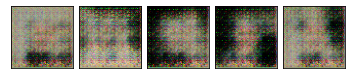

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.39it/s]
Discriminator loss: 1.3754412465625339
Generator loss:     0.7808641284805686
Saved checkpoint.


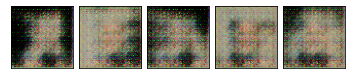

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.98it/s]
Discriminator loss: 1.342807372411092
Generator loss:     0.7669265187747211
Saved checkpoint.


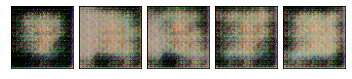

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.58it/s]
Discriminator loss: 1.3182575835122003
Generator loss:     0.8180234532447723
Saved checkpoint.


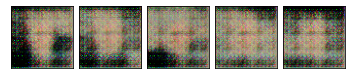

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.81it/s]
Discriminator loss: 1.3361544873979356
Generator loss:     0.7937261990670664
Saved checkpoint.


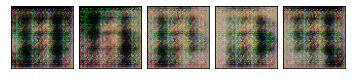

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.71it/s]
Discriminator loss: 1.2727720472547743
Generator loss:     0.8686267305188154
Saved checkpoint.


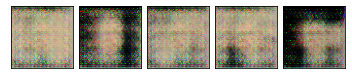

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.94it/s]
Discriminator loss: 1.2839637994766235
Generator loss:     0.900172205819846
Saved checkpoint.


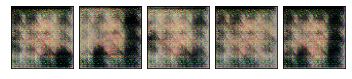

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.64it/s]
Discriminator loss: 1.2690840827094183
Generator loss:     0.9436202388892533
Saved checkpoint.


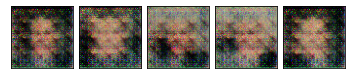

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.10it/s]
Discriminator loss: 1.2476599878735013
Generator loss:     1.0462908196986218
Saved checkpoint.


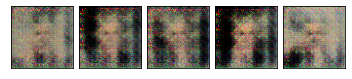

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.37it/s]
Discriminator loss: 1.2285043795903523
Generator loss:     1.1180107232356298
Saved checkpoint.


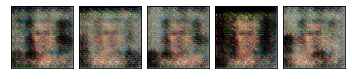

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
Discriminator loss: 1.2622141043345134
Generator loss:     1.1464644649737963
Saved checkpoint.


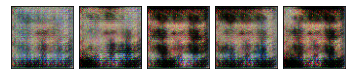

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.50it/s]
Discriminator loss: 1.2347410519917805
Generator loss:     1.193457421440241
Saved checkpoint.


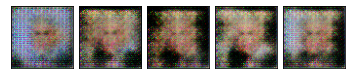

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.89it/s]
Discriminator loss: 1.3299562003877428
Generator loss:     1.0824237503108687
Saved checkpoint.


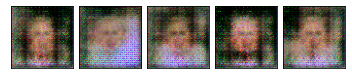

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.92it/s]
Discriminator loss: 1.2741800944010417
Generator loss:     1.1956444040583636
Saved checkpoint.


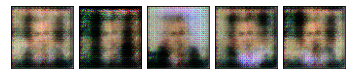

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.75it/s]
Discriminator loss: 1.294734729660882
Generator loss:     1.0948726495515393
Saved checkpoint.


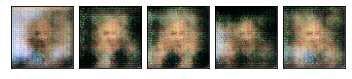

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
Discriminator loss: 1.2989264064364963
Generator loss:     1.1049258598938236
Saved checkpoint.


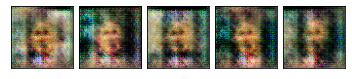

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.83it/s]
Discriminator loss: 1.295619593726264
Generator loss:     1.1329880298405668
Saved checkpoint.


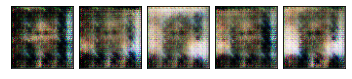

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.45it/s]
Discriminator loss: 1.313554949230618
Generator loss:     1.1539135079479765
Saved checkpoint.


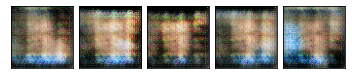

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.34it/s]
Discriminator loss: 1.3241314888000488
Generator loss:     1.170422910387283
Saved checkpoint.


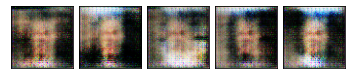

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.38it/s]
Discriminator loss: 1.3653312524159749
Generator loss:     0.965403343376046
Saved checkpoint.


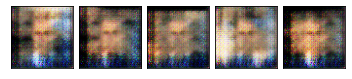

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.65it/s]
Discriminator loss: 1.338017423947652
Generator loss:     0.9620620082624001
Saved checkpoint.


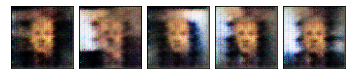

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.42it/s]
Discriminator loss: 1.308384617169698
Generator loss:     1.049381013838689
Saved checkpoint.


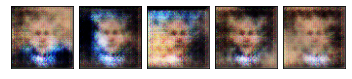

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
Discriminator loss: 1.3004032770792644
Generator loss:     1.097392932929613
Saved checkpoint.


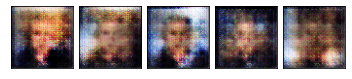

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.50it/s]
Discriminator loss: 1.375424067179362
Generator loss:     1.04370581566191
Saved checkpoint.


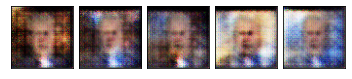

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.03it/s]
Discriminator loss: 1.3229139778349135
Generator loss:     1.0707499814671546
Saved checkpoint.


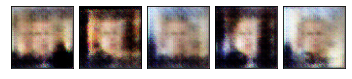

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.48it/s]
Discriminator loss: 1.271292554007636
Generator loss:     1.1722854056120984
Saved checkpoint.


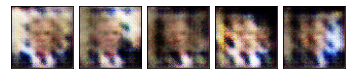

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.18it/s]
Discriminator loss: 1.396257095866733
Generator loss:     0.9469775929596602
Saved checkpoint.


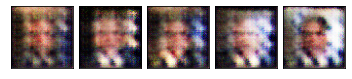

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.55it/s]
Discriminator loss: 1.3221351040734186
Generator loss:     1.133979457939886
Saved checkpoint.


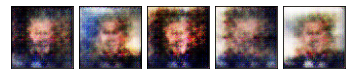

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.34it/s]
Discriminator loss: 1.314993487464057
Generator loss:     1.1349129023542526
Saved checkpoint.


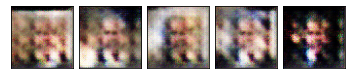

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.24it/s]
Discriminator loss: 1.24960196018219
Generator loss:     1.198159050744098
Saved checkpoint.


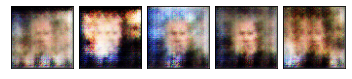

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.36it/s]
Discriminator loss: 1.2780294550789728
Generator loss:     1.2187786326394987
Saved checkpoint.


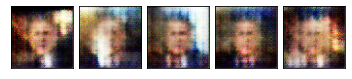

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.63it/s]
Discriminator loss: 1.3014436430401273
Generator loss:     1.1058492842618017
Saved checkpoint.


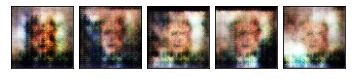

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.60it/s]
Discriminator loss: 1.2344050539864435
Generator loss:     1.1954310141262292
Saved checkpoint.


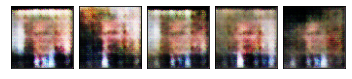

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.53it/s]
Discriminator loss: 1.2608452240626018
Generator loss:     1.222261111629603
Saved checkpoint.


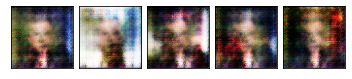

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.08it/s]
Discriminator loss: 1.2947543727027044
Generator loss:     1.253147274782768
Saved checkpoint.


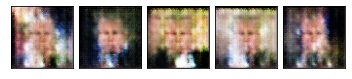

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.44it/s]
Discriminator loss: 1.2578803565767076
Generator loss:     1.2363461680923302
Saved checkpoint.


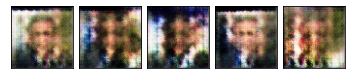

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
Discriminator loss: 1.2045063707563612
Generator loss:     1.2605189013763574
Saved checkpoint.


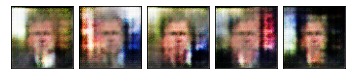

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.61it/s]
Discriminator loss: 1.2607431676652696
Generator loss:     1.2056761213783451
Saved checkpoint.


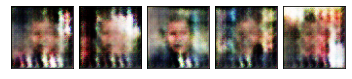

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
Discriminator loss: 1.2177287075254652
Generator loss:     1.2516336924050733
Saved checkpoint.


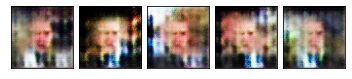

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
Discriminator loss: 1.2310403452979193
Generator loss:     1.3425945267626032
Saved checkpoint.


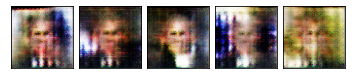

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.59it/s]
Discriminator loss: 1.1137394905090332
Generator loss:     1.3549973801371533
Saved checkpoint.


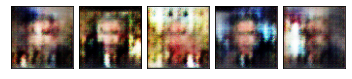

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.40it/s]
Discriminator loss: 1.239765187104543
Generator loss:     1.7354069210859044
Saved checkpoint.


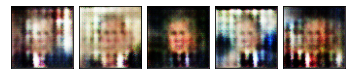

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.41it/s]
Discriminator loss: 1.5682451725006104
Generator loss:     1.0674785424916822
Saved checkpoint.


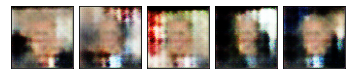

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.66it/s]
Discriminator loss: 1.3287991550233629
Generator loss:     0.8541350022240497
Saved checkpoint.


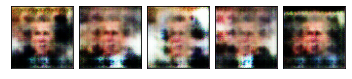

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.93it/s]
Discriminator loss: 1.330302013291253
Generator loss:     0.9222158245745479
Saved checkpoint.


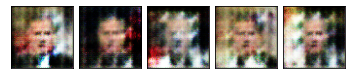

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
Discriminator loss: 1.2510324716567993
Generator loss:     1.0397625584143
Saved checkpoint.


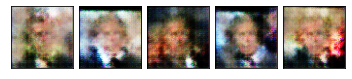

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.68it/s]
Discriminator loss: 1.126594106356303
Generator loss:     1.26382504581811
Saved checkpoint.


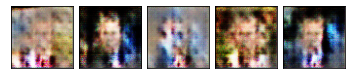

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.42it/s]
Discriminator loss: 1.0656088127030268
Generator loss:     1.5672939683023566
Saved checkpoint.


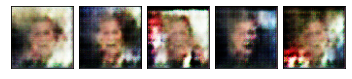

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.06it/s]
Discriminator loss: 1.1903152333365545
Generator loss:     1.4777411676753203
Saved checkpoint.


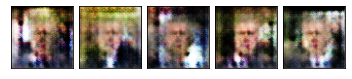

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.48it/s]
Discriminator loss: 1.0668781465954251
Generator loss:     1.5055496250852436
Saved checkpoint.


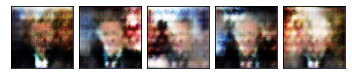

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.78it/s]
Discriminator loss: 1.1407755083507962
Generator loss:     1.4345622015607795
Saved checkpoint.


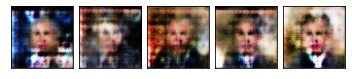

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.64it/s]
Discriminator loss: 0.8979518877135383
Generator loss:     1.7990408212963398
Saved checkpoint.


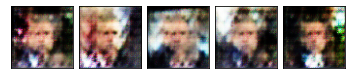

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.60it/s]
Discriminator loss: 0.962829417652554
Generator loss:     1.8319872571362663
Saved checkpoint.


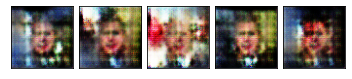

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
Discriminator loss: 1.341368834177653
Generator loss:     1.6464662131407346
Saved checkpoint.


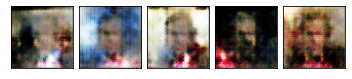

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.37it/s]
Discriminator loss: 1.0946143998040094
Generator loss:     1.2958613554615304
Saved checkpoint.


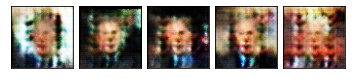

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.40it/s]
Discriminator loss: 1.0202213658226862
Generator loss:     1.5252583174883325
Saved checkpoint.


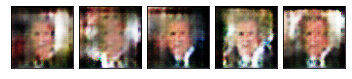

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.67it/s]
Discriminator loss: 1.1005792750252619
Generator loss:     1.6038714213430907
Saved checkpoint.


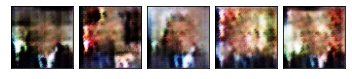

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.14it/s]
Discriminator loss: 0.9039631419711642
Generator loss:     1.641248757106585
Saved checkpoint.


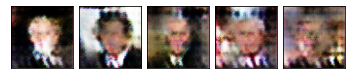

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.28it/s]
Discriminator loss: 1.0317884749836392
Generator loss:     1.7640950032911482
Saved checkpoint.


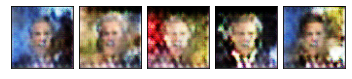

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.78it/s]
Discriminator loss: 0.8807462784979079
Generator loss:     1.8037049703912014
Saved checkpoint.


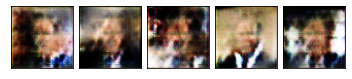

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.70it/s]
Discriminator loss: 1.2554319832060072
Generator loss:     1.6154332055411613
Saved checkpoint.


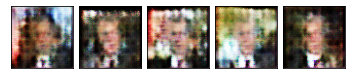

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.60it/s]
Discriminator loss: 0.9833441509140862
Generator loss:     1.759248771709423
Saved checkpoint.


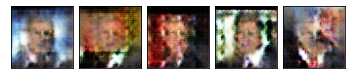

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.68it/s]
Discriminator loss: 0.8507803678512573
Generator loss:     1.9244268401019273
Saved checkpoint.


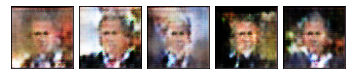

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.52it/s]
Discriminator loss: 0.9911718169848124
Generator loss:     1.9096338312684529
Saved checkpoint.


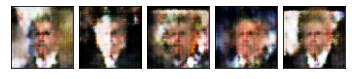

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.17it/s]
Discriminator loss: 0.9514933956993951
Generator loss:     1.8827985943877503
Saved checkpoint.


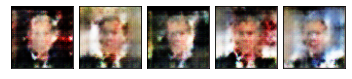

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.48it/s]
Discriminator loss: 0.9212527010175917
Generator loss:     1.9257754395172084
Saved checkpoint.


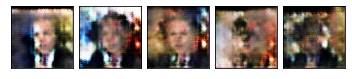

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.55it/s]
Discriminator loss: 1.0014385514789157
Generator loss:     1.8172069802216386
Saved checkpoint.


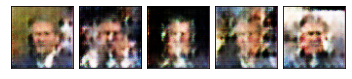

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.52it/s]
Discriminator loss: 0.8879331151644388
Generator loss:     1.8678303291832015
Saved checkpoint.


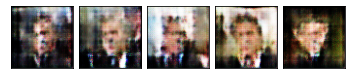

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.48it/s]
Discriminator loss: 0.9971203340424432
Generator loss:     1.9116953890879822
Saved checkpoint.


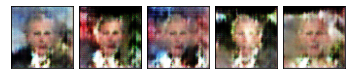

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.64it/s]
Discriminator loss: 0.9938570128546821
Generator loss:     1.9047162329419918
Saved checkpoint.


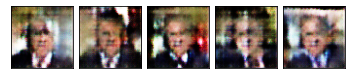

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.64it/s]
Discriminator loss: 0.8964269359906515
Generator loss:     1.881582564565529
Saved checkpoint.


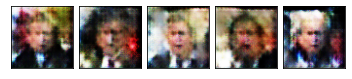

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.65it/s]
Discriminator loss: 1.0164742668469746
Generator loss:     1.8138188832083992
Saved checkpoint.


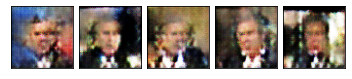

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.34it/s]
Discriminator loss: 0.8027907742394341
Generator loss:     1.9565397760638108
Saved checkpoint.


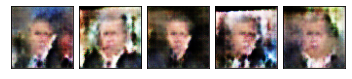

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
Discriminator loss: 0.7901863720681932
Generator loss:     2.106996719635472
Saved checkpoint.


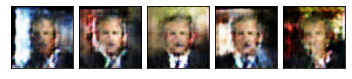

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
Discriminator loss: 1.0684383312861125
Generator loss:     1.9045399997495045
Saved checkpoint.


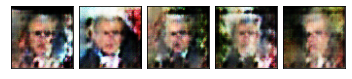

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.57it/s]
Discriminator loss: 0.8462789257367452
Generator loss:     2.02028604676966
Saved checkpoint.


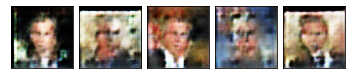

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:01<00:00,  6.74it/s]
Discriminator loss: 0.8223534425099691
Generator loss:     2.1133740053129317
Saved checkpoint.


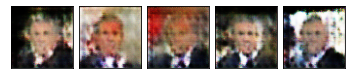

In [251]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


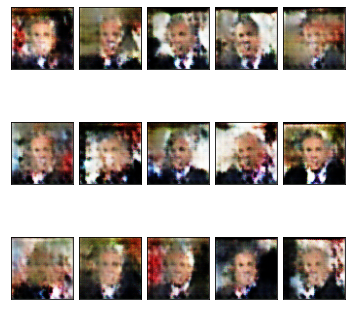

In [252]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [253]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [254]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [255]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [256]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

